In [1]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS Crime_Rate, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)

In [2]:
# Get rid of the redundant decimal places 
crime_type.Crime_Rate = crime_type.Crime_Rate.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 
crime_type.tail() 

,Community,Crime_Rate,Primary_Type
2022,9,2.6,ROBBERY
2023,9,1.2,SEX OFFENSE
2024,9,0.4,STALKING
2025,9,84.2,THEFT
2026,9,0.2,WEAPONS VIOLATION


In [83]:
crime_type.Primary_Type.value_counts()

NARCOTICS                           78
ASSAULT                             78
BATTERY                             78
DECEPTIVE PRACTICE                  78
CRIMINAL TRESPASS                   78
MOTOR VEHICLE THEFT                 78
CRIMINAL DAMAGE                     78
THEFT                               78
OTHER OFFENSE                       78
PUBLIC PEACE VIOLATION              77
OFFENSE INVOLVING CHILDREN          77
ROBBERY                             77
SEX OFFENSE                         77
WEAPONS VIOLATION                   77
LIQUOR LAW VIOLATION                77
CRIM SEXUAL ASSAULT                 77
ARSON                               77
STALKING                            77
BURGLARY                            77
KIDNAPPING                          76
INTERFERENCE WITH PUBLIC OFFICER    76
INTIMIDATION                        75
HOMICIDE                            75
GAMBLING                            73
PROSTITUTION                        71
OBSCENITY                

In [3]:
# Get socioeconomics data 
socioeconomics = pd.read_csv("Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)
crime_type.head(15)

,Community Area Number,Crime_Rate,Primary_Type
0,0.0,0.2,ASSAULT
1,0.0,1.2,BATTERY
2,0.0,0.2,CRIMINAL DAMAGE
3,0.0,0.4,CRIMINAL TRESPASS
4,0.0,1.0,DECEPTIVE PRACTICE
5,0.0,0.2,MOTOR VEHICLE THEFT
6,0.0,0.4,NARCOTICS
7,0.0,0.8,OTHER OFFENSE
8,0.0,1.6,THEFT
9,1.0,4.6,ARSON


In [4]:
socioeconomics.head()

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [86]:
crime_df = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')

In [87]:
crime_df.head()

,Community Area Number,Crime_Rate,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [7]:
# geopandas starts from here

import matplotlib.pyplot as plt
import geopandas as gpd

In [64]:
tract_df = gpd.read_file("chicomm/chicomm.shp")
# tract_df = tract_df[tract_df["COUNTYFP"] == "031"]
# tract_df.rename(columns = {"NAME" : "Census Tract"}, inplace = True)

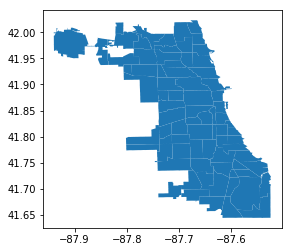

In [65]:
tract_df.plot()

In [66]:
tract_df.head()

,CHICOMNO,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
0,0047,47,Burnside,30179,25946,9025,54900,371,POLYGON ((-87.60019683837891 41.73659896850586...
1,0054,54,Riverdale,7360,6401,3952,46000,115,POLYGON ((-87.61219787597656 41.68529891967773...
2,0001,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...
3,0002,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...
4,0003,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...


In [67]:
tract_df.rename(columns = {'CHICOMNO':'Community Area Number'}, inplace = True)

In [68]:
tract_df.set_index('Community Area Number', inplace = True)
# .sort_index(inplace = True)
tract_df.index = tract_df.index.astype(int)

In [69]:
tract_df.sort_index(inplace = True)

In [70]:
tract_df.head()

,DISTNAME,DISTITLE,FAMINC,HOUSINC,PERCAPINC,MEDVALOOH,MEDRENT,geometry
Community Area Number,,,,,,,,
1,1,Rogers Park,27330,23902,12603,108400,429,POLYGON ((-87.67801666242399 42.02297966661155...
2,2,West Ridge,36791,31408,14792,127700,491,POLYGON ((-87.70990500473188 42.01177281268769...
3,3,Uptown,22378,19711,12389,137800,378,POLYGON ((-87.65519714354694 41.97660064768972...
4,4,Lincoln Square,31403,26344,13091,116600,427,POLYGON ((-87.68979644774656 41.99079895091486...
5,5,North Center,34739,28941,14132,105400,401,POLYGON ((-87.67910003661368 41.96149826121248...


In [85]:
# from shapely.geometry import Point

In [84]:
# geometry = [Point(xy) for xy in zip(mix_df.Longitude, mix_df.Latitude)]
# crime_coords = gpd.GeoDataFrame(mix_df,
#                                 crs = {'init': 'epsg:4269'}, geometry=geometry)

In [95]:
crime_sum = crime_df.groupby('Community Area Number').sum()

In [102]:
crime_sum.head()

,Crime_Rate,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
Community Area Number,,,,,,,,
1,5615.4,207.9,637.2,234.9,491.4,742.5,646353,1053.0
2,4805.8,218.4,481.6,246.4,582.4,1078.0,645120,1288.0
3,5203.2,106.4,672.0,249.2,330.4,621.6,1002036,560.0
4,2527.2,88.4,283.4,213.2,348.4,663.0,975624,442.0
5,2190.6,7.8,195.0,135.2,117.0,681.2,1485198,156.0


In [100]:
crime_sum.index = crime_sum.index.astype(int)

In [108]:
crime_sum_geo = tract_df.join(crime_sum)

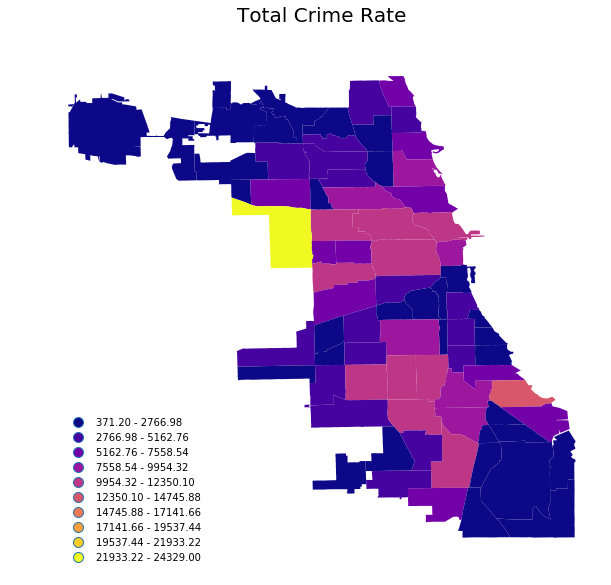

In [167]:
ax_sum = crime_sum_geo.plot(column = 'Crime_Rate', cmap = 'plasma', scheme = 'equal_interval',
                            k = 10, linewidth = 2,
                            legend = True, figsize = (10, 10),
                            )
ax_sum.set_title("Total Crime Rate", fontsize = 20, y = 1.05)
ax_sum.get_legend().set_bbox_to_anchor((0.3, 0.3))
ax_sum.get_legend().get_frame().set_linewidth(0)
ax_sum.set_axis_off()


In [168]:
ax_sum.figure.savefig('Total Crime Rate.png')

In [ ]:
# building interactive map

